In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
path = "/store/user/ekoenig/TTAnalysis/NTuples/2018/preselection/Run2_UL/RunIISummer20UL18NanoAODv9/TTJets/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/"
# basepath = "/store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/"

# masslist = ["MX_700_MY_300",
#             "MX_800_MY_300",
#             "MX_800_MY_350",
#             "MX_900_MY_300",
#             "MX_900_MY_400",
#             "MX_1000_MY_300",
#             "MX_1000_MY_450",
#             "MX_1200_MY_500",]

fileMap = {
    "sig":[
        f"{path}/ntuple_{i}.root"
        for i in range(5)
    ],
    "bkg":[
        # f"{basepath}/Run2_Autumn18/QCD/*/ntuple.root",
        # f"{basepath}/Run2_UL/*/TTJets/*/ntuple_training.root"
    ],
}

signal = ObjIter([ Tree(fileMap['sig']) ])
bkg = ObjIter([ Tree(f) for f in fileMap['bkg'] ])

100%|██████████| 5/5 [00:12<00:00,  2.54s/it]


In [3]:
"""
Events need to be weighted by
    weight = xsec * genWeight / Sum(all the genWeights)
""";

In [4]:
signal = signal.apply(EventFilter('fully_resolved', filter=lambda t:t.nfound_select==6))

In [5]:
""" 
We want the signal to be weightd to the same yield
"""

def normalize_signal(t):
    total = ak.sum(t.scale)

    if t.is_signal:
        norm = 1/total 
    else:
        norm = 1

    t.extend(weight=norm*t.scale)
    return (t.sample, norm)

(signal+bkg).apply(normalize_signal)

[('TTJets', 1)]

In [6]:
"""
We want to use the absolute value of the event weight
but we want the event sum to stay the same
we do this for all samples (signal, QCD, TTbar)
"""

def use_abs_weight(t):

    abs_weight = np.abs(t.weight)

    abs_total = ak.sum(abs_weight)
    total = ak.sum(t.weight)

    norm = total/abs_total

    t.extend(abs_weight=norm*abs_weight)
    return (t.sample, norm)

""" 
We can use the normalizations calculated for each sample to weight any file separately in parallel
"""

(signal+bkg).apply(use_abs_weight)


[('TTJets', 1.0)]

In [8]:
""" 
Now we want each sample group to be weightd to same number of events
"""

def use_sample_norm(sample):
    abs_weight = sample.abs_weight.cat
    total = ak.sum(abs_weight)
    norm = 1/total

    sample.apply(lambda t : t.extend(sample_norm_weight=norm*t.abs_weight))
    return norm

# print(use_sample_norm(bkg))
print(use_sample_norm(signal))
# signal.apply(lambda t:t.extend(sample_norm_weight=t.abs_weight))

1.6867486510735024


100%|██████████| 1/1 [03:00<00:00, 180.14s/it]


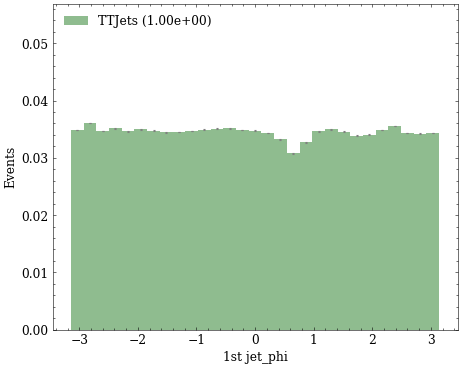

In [11]:
"""
A final check, If we use these new weights. We should find that for each signal sample (there are 3 used here) they should scale to 1/3 * total(background)
"""
study.quick( 
    signal+bkg,
    legend=True,
    scale=lambda t : t.sample_norm_weight/t.scale,
    lumi=None,
    varlist=['jet_phi[:,0]']
)

In [12]:
""" 
Finally, the probabilities in the entire dataset may be much less than 1
This is related to the number of expected events that this dataset would yield
However, we want to make sure we get the most amount of data that we can
We can fix this by scaling the entire dataset so that the maximum weight is 1
"""

def use_dataset_norm(dataset):

    max_weight = np.max(dataset.sample_norm_weight.cat)
    norm = 1/max_weight 

    dataset.apply(lambda t : t.extend(dataset_norm_weight=norm*t.sample_norm_weight))
    return norm

use_dataset_norm(signal+bkg)

11848058.999999987

100%|██████████| 1/1 [00:03<00:00,  3.49s/it]


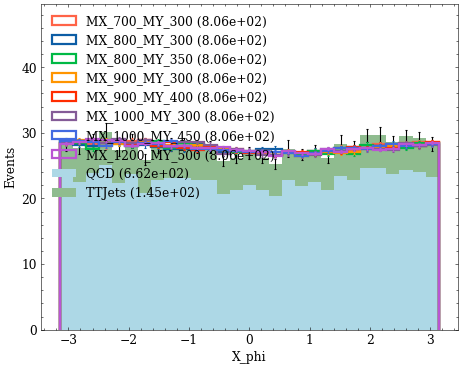

In [16]:
"""
A final check, If we use these new weights. We should find that for each signal sample (there are 3 used here) they should scale to 1/3 * total(background)
"""
study.quick( 
    signal+bkg,
    legend=True,
    scale=lambda t : t.dataset_norm_weight/t.scale,
    lumi=None,
    varlist=['X_phi']
)

A final test, is your bold...

* We can sample events from the dataset, 
* check to make sure that the composition of the events is 50/50 signal background
* And that the distribution of the sampled dataset matches that of the entire dataset

In [24]:
weight = (signal+bkg).dataset_norm_weight.cat.to_numpy()

In [26]:
is_bkg = (signal.Run.apply(lambda r : ak.zeros_like(r))+bkg.Run.apply(lambda r : ak.ones_like(r))).cat.to_numpy()

In [27]:
var = (signal+bkg).X_m.cat.to_numpy()
bins = np.linspace(500,2000,30)

In [28]:
true_bkg_var = var[is_bkg==1]
true_bkg_weight = weight[is_bkg==1]

In [29]:
import numba 

@numba.jit
def n_rand_indices(weights : np.array, indices : np.array, n=1):
    keep_indices = []
    for _ in range(n):
        randwgt = np.random.random(size=len(weights))
        keep_indices.append( indices[randwgt < weights] )
    return keep_indices
    

@numba.jit
def iter_sample_events(weights : np.array, up_sample=True, max_resample=10, weight_scale=1):
    all_indices = np.arange(len(weights))
    randwgt = np.random.uniform(low=0, high=weight_scale, size=len(weights))
    keep_flags = randwgt < weights
    keep_indices = all_indices[keep_flags]
    if up_sample:
        n_repeats = len(weights) // max(1, int(keep_flags.sum()))
        if n_repeats > max_resample:
            n_repeats = max_resample

        keep_indices = [keep_indices] + n_rand_indices(weights, all_indices, n=n_repeats-1)
        keep_indices = np.concatenate(keep_indices)
    return keep_indices

In [32]:
# event_index = iter_sample_events(weight, up_sample=True, max_resample=100)
event_index = iter_sample_events(weight, up_sample=True, max_resample=10)
select_var = var[event_index]
select_is_bkg = is_bkg[event_index]
event_index.shape,select_is_bkg.mean()

((16269,), 0.5015673981191222)

(<Figure size 650x650 with 2 Axes>,
 <AxesSubplot:ylabel='PDF'>,
 [HistoList<[<root.plotUtils.histogram.Histo object at 0x7f0a33eda820>, <root.plotUtils.histogram.Histo object at 0x7f0a33f4ed00>]>])

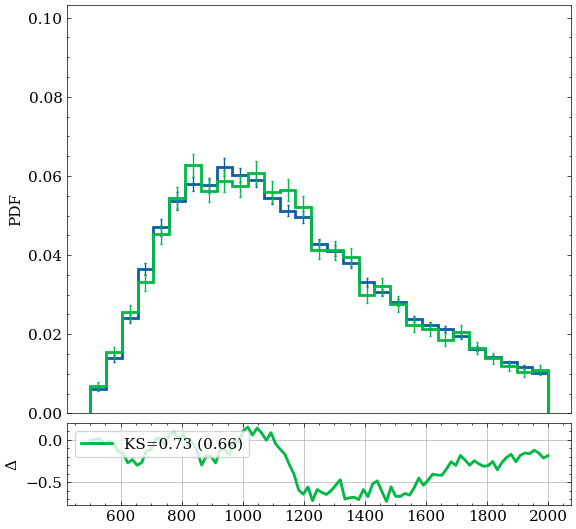

In [33]:
root.hist_multi(
    [true_bkg_var, select_var[select_is_bkg==1]],
    bins=bins,
    weights=[true_bkg_weight],
    efficiency=True,
    **root.study.kstest,
)